In [1]:
import os, sys

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')
#os.chdir('/content/drive/MyDrive/fraud_detection/notebooks')
#!ls

In [2]:
# primero todas las librerías por bloques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import warnings
from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import plot_confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier

In [3]:
# opciones de visualización
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [4]:
def top_correlation (df,metodo='pearson',limit_inf=0.8,limit_sup=1,socioc_num=False):
    '''
    Devuelve los pares de variables entre unos limites de asoc./correlación como frame,
    junto con su coeficiente, ordenados de mayor a menor.
       
    Args:
     param1: Datafram e a estudiar.
     param2: Metodo de cálculo de la aociación.
     param3: limite inferior del coef.
     param4: limite superior del coef.
     
     
     Returns:
     Pandas dataframe 
    '''
    
    if metodo=='pearson':
      corr_matrix= df.corr(metodo)
    
    elif metodo=='spearman':
      candidatos=[col for col in df.columns if col in categorical_vars ]
      for col in candidatos:
        df[col] = pd.factorize(df[col])[0]
      corr_matrix = df.apply(pd.to_numeric, errors='ignore').corr(metodo)
    else:
      print('Metodo no soportado')
      return None

    
       
    correlation = (corr_matrix.where(
                np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_)).
                stack().
                sort_values(ascending=False))
    
    correlation = pd.DataFrame(correlation).reset_index()
    correlation.columns=["Variable_1","Variable_2","Correlacion"]
    correlation = (correlation.reindex(correlation.Correlacion.abs().
                     sort_values(ascending=False).index).
                    reset_index().
                    drop(["index"],axis=1))
    
           
    return correlation[correlation['Correlacion'].abs().  \
                       between(limit_inf,limit_sup,inclusive='right')]

In [5]:
def get_corr_matrix(dataset = None, 
                    isnumeric=True, 
                    size_figure=[12,10],
                    limit=0):
    '''
    Genera gráficos representando toda la matriz de correlación.
     Permite aplicar pearson a las variables númericas o spearmana todo el conjunt ode variables.
    
    Args:
    param1: Pandas Df de datos.
    param2: Sí True, pearson, False Speaarman.
    param3: Tamaño de figura de salida.
    param4: Limite inferior del coeficiente de correlación a mostrar.
    
             
    Returns:
    Sns heatmap.
    
    '''
    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    
    if isnumeric:
        metodo='pearson'
    else:
        metodo='spearman'
        dataset=dataset.apply(pd.to_numeric, errors='ignore')
        for col in categorical_vars:
          dataset[col] = pd.factorize(dataset[col])[0]
    sns.set(style="white")
    
    # Computa la matriz de correlación.
    corr = dataset.corr(method=metodo)
    
    # Para poder aplicar limite inferior.
    corr=corr[abs(corr) >=limit].fillna(0)
    
    # autocorrelacion a cero, evita distracciones.
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    
    # Genera mascara para dibujar solo el triangulo inferior en heatmap.
    matrix=np.triu(corr)
    

    # Fija tamaño fuente en funcion del número de columans.
    if len(corr)<40: 
        fontsize= 3 
    else: 
        fontsize= 3;
    
    if metodo == 'pearson':
        f, ax = plt.subplots(figsize=size_figure)
        sns.heatmap(corr,
                    center=0,                    
                    square=True,
                    linewidths=.25,
                    cmap ="vlag",
                    annot=True,fmt=".1%",annot_kws={"fontsize":8},
                    mask=matrix,cbar=True,
                    cbar_kws={"shrink": .5}) 
    else:
        f, ax = plt.subplots(figsize=size_figure)
        sns.heatmap(corr,
                    center=0,
                    square=True,
                    cbar=True, 
                    cmap ="vlag",
                    mask=matrix,
                    annot=True,fmt=".1%",annot_kws={"fontsize":8},
                    cbar_kws={"shrink": .5})
        ticks = np.arange(corr.shape[0]) + 0.5
        ax.set_xticks(ticks)
        ax.set_xticklabels(corr.columns, rotation=90, fontsize=10)
        ax.set_yticks(ticks)
        ax.set_yticklabels(corr.index, rotation=360, fontsize=10)
        ax.set_title('correlation matrix')
 
    plt.tight_layout()
    
    
    return None

In [6]:
data = pd.read_parquet('../data/fraud_detection_engenering.parquet')
data.columns= data.columns.str.lower()

Consideramos que el contador de orden de fraude, es una caracteristica con la que no podemos contar en nuestros modelos, a riesgo de caer en lekeage. Las operacioens de fraude no se marcan inmediatamente, tendrá que ser detectado por el titular de la cuenta cuando vea que se la han vaciado, sería muy raro que fuese marcado inmediatamente. Lo normal es que se detecte con horas o dias de retraso.

In [7]:
# Para evitar lekeage
if 'fraud_order' in data.columns:
  data=data.drop('fraud_order',axis=1)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 27 columns):
 #   Column            Non-Null Count    Dtype   
---  ------            --------------    -----   
 0   step              1048575 non-null  int64   
 1   type              1048575 non-null  category
 2   amount            1048575 non-null  float64 
 3   gender            1048575 non-null  category
 4   device            1048575 non-null  category
 5   connection_time   1048575 non-null  float64 
 6   nameorig          1048575 non-null  category
 7   race              1048575 non-null  category
 8   oldbalanceorg     1048575 non-null  float64 
 9   age               1048575 non-null  int64   
 10  newbalanceorig    1048575 non-null  float64 
 11  zone              1048575 non-null  category
 12  user_number       1048575 non-null  int64   
 13  namedest          1048575 non-null  category
 14  user_connections  1048575 non-null  int64   
 15  security_alert    1048575 non-nu

In [9]:
data[['segmento','fraud_rules']]=data[['segmento','fraud_rules']].astype('category')

In [10]:
categorical_vars=[x for x in data.columns if data[x].dtypes=='category']
numerical_vars = [[x for x in data.columns if data[x].dtypes !='category']]


## Estudio de correlaciones. 
### Variables númericas. Pearson.
Manajamos 18 varaibles númericas ( incluido el target, que dejamso como númerica, para que nos lo realcione con todas las variables).
Empezamos por aplicar pearson a numericas, y que nos detecte la correlacion lineal entre los pares de variables.


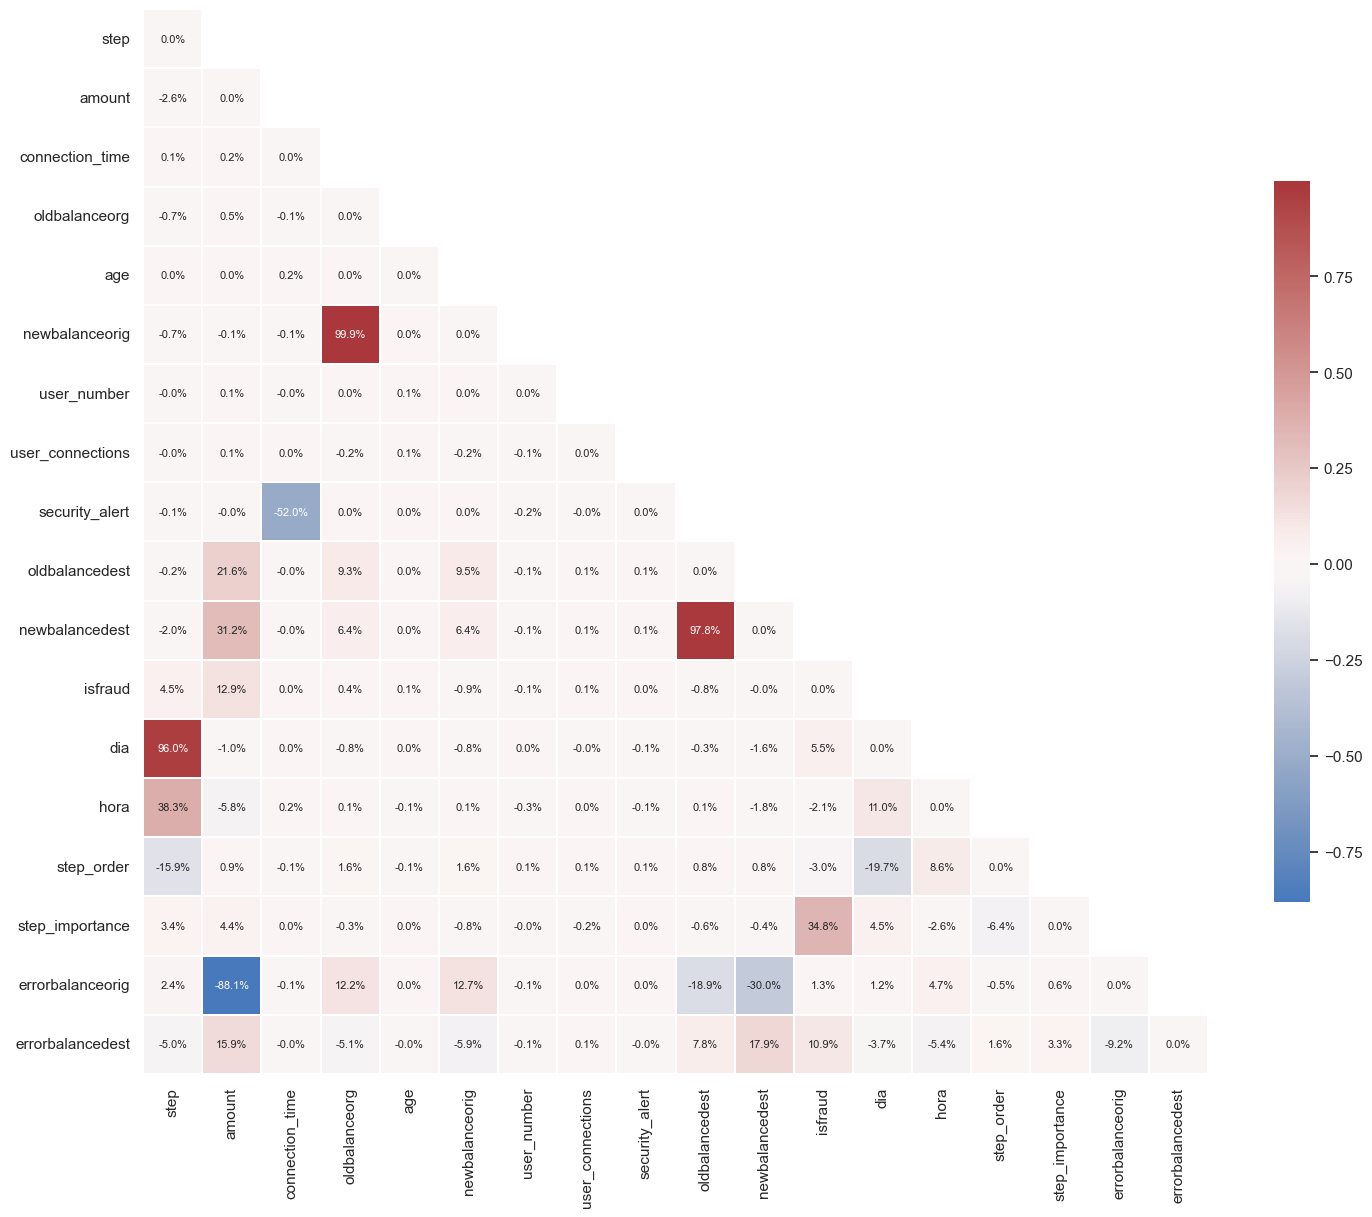

In [11]:
get_corr_matrix(dataset = data, 
                    isnumeric=True, 
                    size_figure=[15,15],
                    limit=0)

Los lod y new balance es lógico que se encuentren altamente correlacionados, al igual de dia,hora con step. 
Destacamos como step_importancie está correlacionada como habiamos visto con isfraud, ya que las primeras operacioens de cada step son mas proclives a ser fraude.


In [12]:
top_correlation(data,metodo='pearson',limit_inf=0.3)

,Variable_1,Variable_2,Correlacion
0,oldbalanceorg,newbalanceorig,0.999
1,oldbalancedest,newbalancedest,0.978
2,step,dia,0.960
3,amount,errorbalanceorig,-0.881
4,connection_time,security_alert,-0.520
5,step,hora,0.383
6,isfraud,step_importance,0.348
7,amount,newbalancedest,0.312


### Correlacion entre todas las variables. Spearman.
Sabemos que Spearman solo nos detectará correlacioens entre variables cuya relación sea monotonica, pero Kramners se eternizaba en su cálculo.

Mediremos la fuerza y la dirección de la asociación entre las variables clasificadas. 



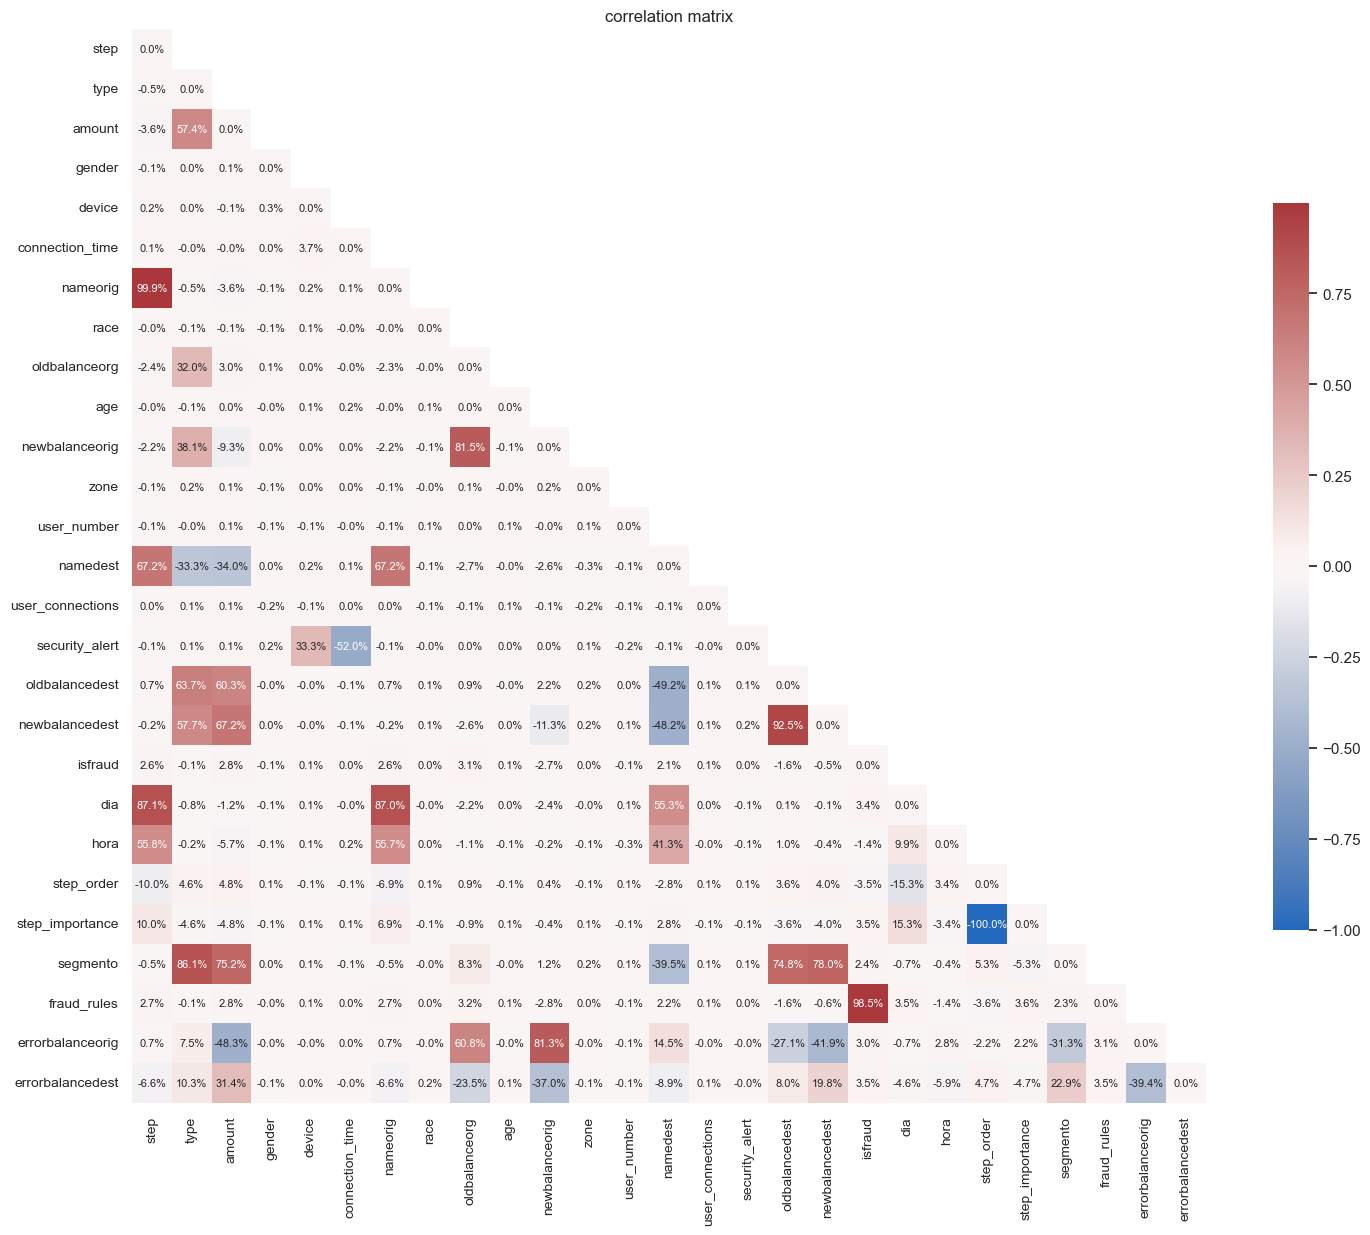

In [13]:
get_corr_matrix(dataset = data, 
                    isnumeric=False, 
                    size_figure=[15,15],
                    limit=0)

Detecta la relación inversa entre step_order y step_importance de manera perfecta, prescindiremso de step_order.
Los nombres, considerados como la aparición por primera vez se relacionan con step. Borraremos los nombres.
Nuestra regla de fraude, es un cañon detectando fraud, y así lo detecta la correlación de Speraman.
Los errores en origen y destino están muy correlacionados, así como como amount y el error en origen. 

Step se relacioan con día y hora de manera muy significativa, dejaremos step y prescindiremos de nuestro día y hora.

Precindiremos de segemto al estar muy correlacionado con type.

Al estar muy relacionado oldbalance y newbalance, nos quedaremos con newbalanceorig para qqudarnos con el saldo incicial de la transacción y oldbalncedestin para que al modelo entre el saldo final de la transacción.

Preferrimos que el modelo pivote sobre errorbalanceorig, en vez de amount, al estar correlacioandos al 97 %.



In [14]:
top_correlation(data,metodo='spearman',limit_inf=0.3)

,Variable_1,Variable_2,Correlacion
0,step_order,step_importance,-1.000
1,step,nameorig,0.999
2,isfraud,fraud_rules,0.985
3,oldbalancedest,newbalancedest,0.925
4,step,dia,0.871
5,nameorig,dia,0.870
6,type,segmento,0.861
7,oldbalanceorg,newbalanceorig,0.815
8,newbalanceorig,errorbalanceorig,0.813
9,newbalancedest,segmento,0.780


A la vista de los resultados de ambas matrices de correlación procedemos a eliminar una de las caracterisiticas que aparecen en los pares de variables alatamente correlacionadas. 
Mantenemos step ante dia y hora.

Eliminamos los nombres al estar altamente asocados a step.

Preferimos mantener, el saldo inicial de la cuenta (oldbalanceorg) y el saldo final de la cuenta destino ( newbalancedest), frente a amount y los "saldos intermedios".

Mantenemos segmento frente a type de las operacioens.

Y eliminamos connection_time al estar muy asociado a security_alert.


In [15]:
features_a_eliminar=['step_order','nameorig','amount','oldbalancedest','dia',	'type', 'newbalanceorig',	'namedest','hora','connection_time']

In [16]:
data=data.drop(features_a_eliminar,axis=1)

Revisamos las crrelaciones alta que mantenemos, y las damos por permisibles.
Nos interesa mantener nuestra regla, veremos sí los modelos mejoran este alto grado de acierto, que conseguimos de manera determinista.

In [17]:
top_correlation(data,metodo='spearman',limit_inf=0.3)

,Variable_1,Variable_2,Correlacion
0,isfraud,fraud_rules,0.985
1,newbalancedest,segmento,0.780
2,oldbalanceorg,errorbalanceorig,0.608
3,newbalancedest,errorbalanceorig,-0.419
4,errorbalanceorig,errorbalancedest,-0.394
5,device,security_alert,0.333
6,segmento,errorbalanceorig,-0.313


In [18]:
# Volvemos  tupo categoria las varibales categoria.
to_category= [col for col in data.columns if col in categorical_vars]
data[to_category] = data[to_category].astype('category')

## Construción de conjunto de entrenamiento y test.
Construimos nuestros sets de entrenamiento y test, con estratificación por el target. De manera que nos aseguramos mantener la misma proporción de isfraud en ambos conjuntos. 

In [19]:
# Hacemos nuestro sets de features y target.
X=data.drop(['isfraud'],axis=1)
y=data['isfraud']

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size=0.20,random_state=42,stratify=y)

In [21]:
!pip install category_encoders
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder

In [22]:
# Construimos dummies para las variables categoricas.

list_columns_cat = [col for col in X_train.columns if col in categorical_vars ]
list_other = list(set(X_train.columns)-set(list_columns_cat))
one = ce.OneHotEncoder(cols=list_columns_cat)
model = one.fit(X_train, y_train)

In [23]:
X_train_t = model.transform(X_train, y_train)
X_test_t = model.transform(X_test, y_test)
len(list(X_train_t.columns))

30

In [24]:
# Estandarizamos todas las variables, media 0, desviacion estandar 1.

scaler = StandardScaler()
model_scaled = scaler.fit(X_train_t)
X_train_scaled = pd.DataFrame(scaler.transform(X_train_t), columns=X_train_t.columns, index=X_train_t.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_t), columns=X_test_t.columns, index=X_test.index)

## Selección de caracterisiticas.

Vamos a realizar una bisqueda de caracteristicas relevantes por varios metodos al objeto de conseguir un set que nos asegure obtener el mejor resultado con el menor número de caracterisitcas implicadas en el modelo. Mediante esta tecnica intentamos salvaguardar al modelo de la maldición de la dimensionalidad, que acarrea generalmnte overfitting. Nos ayudará a que nuestros modelos sean faciles de explicar.

Utilizamos la técnica clásica de intentar limitar a 1/2 de las caracterisiticas originales, en este caso 15. Observaremso como, en este caso, necesitaremos muchas menos.




1. Correlación de Pearson.

Calculamos  el valor absoluto de la correlación de Pearson entre el objetivo y las características numéricas en nuestro conjunto de datos. Mantenemos las n características principales en función de este criterio.

In [25]:

def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    return cor_support, cor_feature
cor_support, cor_feature = cor_selector(X_train_scaled, y_train,15)
print(str(len(cor_feature)), 'selected features')

15 selected features


In [26]:
cor_feature

['race_3',
 'device_4',
 'user_number',
 'device_1',
 'gender_4',
 'user_connections',
 'oldbalanceorg',
 'errorbalanceorig',
 'segmento_2',
 'segmento_1',
 'step',
 'errorbalancedest',
 'step_importance',
 'fraud_rules_1',
 'fraud_rules_2']

2. Chi-2.

En este método, calculamos la métrica de chi-cuadrado entre el objetivo y las variables numéricas y solo seleccionamos la variable con los valores máximos de chi-cuadrado.

Este metodo solo funciona con valores númericos, no negativos, para poder aplicarlo realizamos transformación MinMax a nuestro dataset.

In [27]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler

X_norm = MinMaxScaler().fit_transform(X_train_t)
chi_selector = SelectKBest(chi2, k=15)
chi_selector.fit(X_norm, y_train)
chi_support = chi_selector.get_support()
chi_feature = X_train_t.loc[:,chi_support].columns.tolist()
print(str(len(chi_feature)), 'selected features')

15 selected features


In [28]:
chi_feature

['step',
 'gender_1',
 'gender_4',
 'device_1',
 'device_4',
 'race_1',
 'race_3',
 'oldbalanceorg',
 'security_alert',
 'step_importance',
 'segmento_1',
 'segmento_2',
 'fraud_rules_1',
 'fraud_rules_2',
 'errorbalancedest']

3. Eliminación recursiva de características. RFE.

De la documentación de sk-learn.
El objetivo de la eliminación recursiva de características (RFE) es seleccionar características recursivamente considerando conjuntos de características cada vez más pequeños. 

Primero, el estimador se entrena en el conjunto inicial de características y la importancia de cada característica se obtiene a través de un coef_atributo oa través de un feature_importances_atributo. Luego, las características menos importantes se eliminan del conjunto actual de características. 

Ese procedimiento se repite recursivamente en el conjunto podado hasta que finalmente se alcanza el número deseado de características para seleccionar.

Uusamos LogisticRegression, y el RFE observa el coef_ atributo del LogisticRegressionobjeto

In [29]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=15, step=2, verbose=5)
rfe_selector.fit(X_norm, y_train)
rfe_support = rfe_selector.get_support()
rfe_feature = X_train_t.loc[:,rfe_support].columns.tolist()
print(str(len(rfe_feature)), 'selected features')

Fitting estimator with 30 features.
Fitting estimator with 28 features.
Fitting estimator with 26 features.
Fitting estimator with 24 features.
Fitting estimator with 22 features.
Fitting estimator with 20 features.
Fitting estimator with 18 features.
Fitting estimator with 16 features.
15 selected features


In [30]:
rfe_feature

['step',
 'gender_3',
 'device_2',
 'race_2',
 'race_4',
 'oldbalanceorg',
 'zone_3',
 'zone_4',
 'newbalancedest',
 'step_importance',
 'segmento_1',
 'segmento_2',
 'fraud_rules_1',
 'fraud_rules_2',
 'errorbalancedest']

3. Lasso con SelectFromModel.


SelectFromModel un metatransformador que se puede usar junto con cualquier estimador que asigne importancia a cada característica a través de un atributo específico (como coef_, feature_importances_) o mediante un importance_getter ajuste invocable después.
 Las caracterisicas se consideran sin importancia  y se eliminan si la importancia correspondiente de los valores de las funciones está por debajo del umbral proporcionado como parametro.
 
Se puede usar el max_features como parámetro para establecer un límite en el número de caracteristicas a seleccionar.

In [31]:

from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression

embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l1",solver='liblinear'), max_features=15)
embeded_lr_selector.fit(X_norm, y_train)

embeded_lr_support = embeded_lr_selector.get_support()
embeded_lr_feature = X_train_t.loc[:,embeded_lr_support].columns.tolist()
print(str(len(embeded_lr_feature)), 'selected features')

14 selected features


In [32]:
embeded_lr_feature

['gender_3',
 'gender_4',
 'device_2',
 'device_3',
 'race_1',
 'race_2',
 'race_4',
 'oldbalanceorg',
 'zone_2',
 'zone_3',
 'zone_4',
 'segmento_1',
 'fraud_rules_1',
 'fraud_rules_2']

5. Basado en árbol: SelectFromModel.

Calculamos la importancia de las características utilizando las impurezas de los nodos en cada árbol de decisión.

 En Random Forrest, la importancia de la característica final es el promedio de todas las importancias de características del árbol de decisión.

In [33]:

from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=10), max_features=15)
embeded_rf_selector.fit(X_train_t, y_train)

embeded_rf_support = embeded_rf_selector.get_support()
embeded_rf_feature = X_train_t.loc[:,embeded_rf_support].columns.tolist()
print(str(len(embeded_rf_feature)), 'selected features')

4 selected features


In [34]:
embeded_rf_feature

['step', 'step_importance', 'fraud_rules_1', 'fraud_rules_2']

In [37]:

from sklearn.feature_selection import SelectFromModel
from lightgbm import LGBMClassifier

lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
            reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

embeded_lgb_selector = SelectFromModel(lgbc, max_features=15)
embeded_lgb_selector.fit(X_train_t, y_train)

embeded_lgb_support = embeded_lgb_selector.get_support()
embeded_lgb_feature = X_train_t.loc[:,embeded_lgb_support].columns.tolist()
print(str(len(embeded_lgb_feature)), 'selected features')

8 selected features


In [38]:
embeded_lgb_feature

['step',
 'oldbalanceorg',
 'age',
 'user_number',
 'newbalancedest',
 'fraud_rules_1',
 'errorbalanceorig',
 'errorbalancedest']


6. Boluta.

Algoritmo automatico basado en realizar comparaciones entre las caracterisitcas originales y variaciones aleatorias de las mismas. Se duplica el conjunto de caracterisitcas con variacioens aleatorias de cada una de ellas.

La idea básica es que sí una caracterisitica ofrece una ganancia de información menor que la mayor caracterisitica aleatoria, ésta sera inutil. Repitiendo este experimento un númro de veces, inteacciones, y rechazando o aporbando las caracterisiticas basadonse en uan disitribución binomial construuendo unas areas de aceptación, mantener en tentariva o rechazo.

In [40]:
!pip install Boruta

     ---------------------------------------- 56.6/56.6 kB 3.1 MB/s eta 0:00:00


In [41]:
from boruta import BorutaPy
# sampling in proportion to y labels
rf = RandomForestClassifier(n_jobs=-1, max_depth=5) # cambiar los hiperparametros

# define Boruta feature selection method
feat_selector = BorutaPy(rf, n_estimators=15, max_iter=40,verbose=2, random_state=1)

# find all relevant features 
feat_selector.fit(X_train_t.values, y_train.values) # Importante poner el .values al dataframe, sino dará error

# check selected features - first 15 features are selected
feat_selector.support_

# check ranking of features
feat_selector.ranking_

Iteration: 	1 / 40
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	2 / 40
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	3 / 40
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	4 / 40
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	5 / 40
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	6 / 40
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	7 / 40
Confirmed: 	0
Tentative: 	30
Rejected: 	0
Iteration: 	8 / 40
Confirmed: 	7
Tentative: 	6
Rejected: 	17
Iteration: 	9 / 40
Confirmed: 	7
Tentative: 	6
Rejected: 	17
Iteration: 	10 / 40
Confirmed: 	7
Tentative: 	6
Rejected: 	17
Iteration: 	11 / 40
Confirmed: 	7
Tentative: 	6
Rejected: 	17
Iteration: 	12 / 40
Confirmed: 	7
Tentative: 	3
Rejected: 	20
Iteration: 	13 / 40
Confirmed: 	7
Tentative: 	3
Rejected: 	20
Iteration: 	14 / 40
Confirmed: 	7
Tentative: 	3
Rejected: 	20
Iteration: 	15 / 40
Confirmed: 	7
Tentative: 	3
Rejected: 	20
Iteration: 	16 / 40
Confirmed: 	8
Tentative: 	2
Rejected: 	20
Iteration: 	17 / 

array([ 1, 20, 17,  8, 20, 13, 15,  8, 10, 10, 18, 12, 23,  1,  4, 14, 20,
        7, 20,  5,  5, 15,  1,  1,  3,  2,  1,  1,  1,  1])

In [42]:

embeded_bor_support = feat_selector.support_
embeded_bor_feature = X_train_t.loc[:,embeded_bor_support].columns.tolist()
print(str(len(embeded_bor_feature)), 'selected features')

8 selected features


In [43]:
embeded_bor_feature

['step',
 'oldbalanceorg',
 'newbalancedest',
 'step_importance',
 'fraud_rules_1',
 'fraud_rules_2',
 'errorbalanceorig',
 'errorbalancedest']

RESUMEN DE RESULTADOS Y DECISIÓN.

Construimos un fraame que nos muestra el número de aparecioens de cada caracterisitica en los distintos metodos de selección.
Como no podría ser de otra forma, nuestra fraud_rules, es la primera, destacando tambien step y step_importance.

Las variables de saldo incial origen, los descuadres en origin y dest y los segmentos.


In [44]:

# put all selection together
feature_name = X_train_t.columns.tolist()
feature_selection_df = pd.DataFrame({'Feature':feature_name, 'Pearson':cor_support, 'Chi-2':chi_support, 'RFE':rfe_support, 'Logistics':embeded_lr_support,
                                    'Random Forest':embeded_rf_support, 'LightGBM':embeded_lgb_support})
feature_selection_df['boruta']=np.where(feature_selection_df["Feature"].isin(embeded_bor_feature), True, False)
# count the selected times for each feature
feature_selection_df['Total'] = np.sum(feature_selection_df, axis=1)
# display the top 100
feature_selection_df = feature_selection_df.sort_values(['Total','Feature'] , ascending=False)
feature_selection_df.index = range(1, len(feature_selection_df)+1)
feature_selection_df.head(15)

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,boruta,Total
1,fraud_rules_1,True,True,True,True,True,True,True,7
2,step,True,True,True,False,True,True,True,6
3,oldbalanceorg,True,True,True,True,False,True,True,6
4,fraud_rules_2,True,True,True,True,True,False,True,6
5,step_importance,True,True,True,False,True,False,True,5
6,errorbalancedest,True,True,True,False,False,True,True,5
7,segmento_1,True,True,True,True,False,False,False,4
8,segmento_2,True,True,True,False,False,False,False,3
9,newbalancedest,False,False,True,False,False,True,True,3
10,gender_4,True,True,False,True,False,False,False,3


In [45]:
feature_selection_df[feature_selection_df.Total>3]

,Feature,Pearson,Chi-2,RFE,Logistics,Random Forest,LightGBM,boruta,Total
1,fraud_rules_1,True,True,True,True,True,True,True,7
2,step,True,True,True,False,True,True,True,6
3,oldbalanceorg,True,True,True,True,False,True,True,6
4,fraud_rules_2,True,True,True,True,True,False,True,6
5,step_importance,True,True,True,False,True,False,True,5
6,errorbalancedest,True,True,True,False,False,True,True,5
7,segmento_1,True,True,True,True,False,False,False,4


## DECISIÓN.
Decidimos quedarnos con Boruta como método básico de decisión de caracteriticas. Supone cosntruir modelos con 7 caracterisiticas originales. Con un significado muy claro, los que nos permitirá tener uan alta explicavilidad de los modelos.

In [46]:
embeded_bor_feature

['step',
 'oldbalanceorg',
 'newbalancedest',
 'step_importance',
 'fraud_rules_1',
 'fraud_rules_2',
 'errorbalanceorig',
 'errorbalancedest']

In [47]:
selected_feaures=['step',  'oldbalanceorg', 'newbalancedest', 'step_importance', 'fraud_rules', 'errorbalanceorig', 'errorbalancedest']

## Importancia de las caracteristicas seleccionadas.

Obtenemos por RandomForrest la importancia de las caracterisiticas seleccioandas. En el top 3 aparecen las dos caracteristicas relacionadas con nuestra regla y step_importance.

Y contabilizando train y test, mejora el funcionamiento de nuestra regla simple. La regla determinaba correctamnte, 1109 casos. Pues bien, conseguimos elevar el acierto a 1136, clasificando mal 6 casos.


In [48]:
X_train_selected=X_train[selected_feaures]
X_test_selected=X_test[selected_feaures]

In [49]:
list_columns_cat = [col for col in X_train_selected.columns if col in categorical_vars ]
list_other = list(set(X_train_selected.columns)-set(list_columns_cat))
one = ce.OneHotEncoder(cols=list_columns_cat)
model = one.fit(X_train_selected, y_train)

In [50]:
X_train_selected_t = model.transform(X_train_selected, y_train)
X_test_selected_t = model.transform(X_test_selected, y_test)
len(list(X_train_selected_t.columns))

8

In [51]:
X_train_sel_scaled = pd.DataFrame(scaler.transform(X_train_t), columns=X_train_t.columns, index=X_train_t.index)
X_test_sel_scaled = pd.DataFrame(scaler.transform(X_test_t), columns=X_test_t.columns, index=X_test.index)

In [52]:
# Se escoge la regresión logística
RF = RandomForestClassifier()

# se entrena el modelo con el dataset de entrenamiento
RF.fit(X_train_selected_t, y_train)



RandomForestClassifier()

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
# predice la clase de test
predictions = RF.predict(X_test_selected_t )

# Evaluate predictions
print(RF.score(X_test_selected_t, y_test)*100)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, RF.predict(X_test_selected_t)))

99.9971389743223
[[209487      0]
 [     6    222]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       1.00      0.97      0.99       228

    accuracy                           1.00    209715
   macro avg       1.00      0.99      0.99    209715
weighted avg       1.00      1.00      1.00    209715



In [54]:
predictions = RF.predict(X_train_selected_t )

# Evaluate predictions
print(RF.score(X_train_selected_t, y_train)*100)
print(confusion_matrix(y_train, predictions))
print(classification_report(y_train, RF.predict(X_train_selected_t)))

99.99988079059676
[[837946      0]
 [     1    913]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    837946
           1       1.00      1.00      1.00       914

    accuracy                           1.00    838860
   macro avg       1.00      1.00      1.00    838860
weighted avg       1.00      1.00      1.00    838860



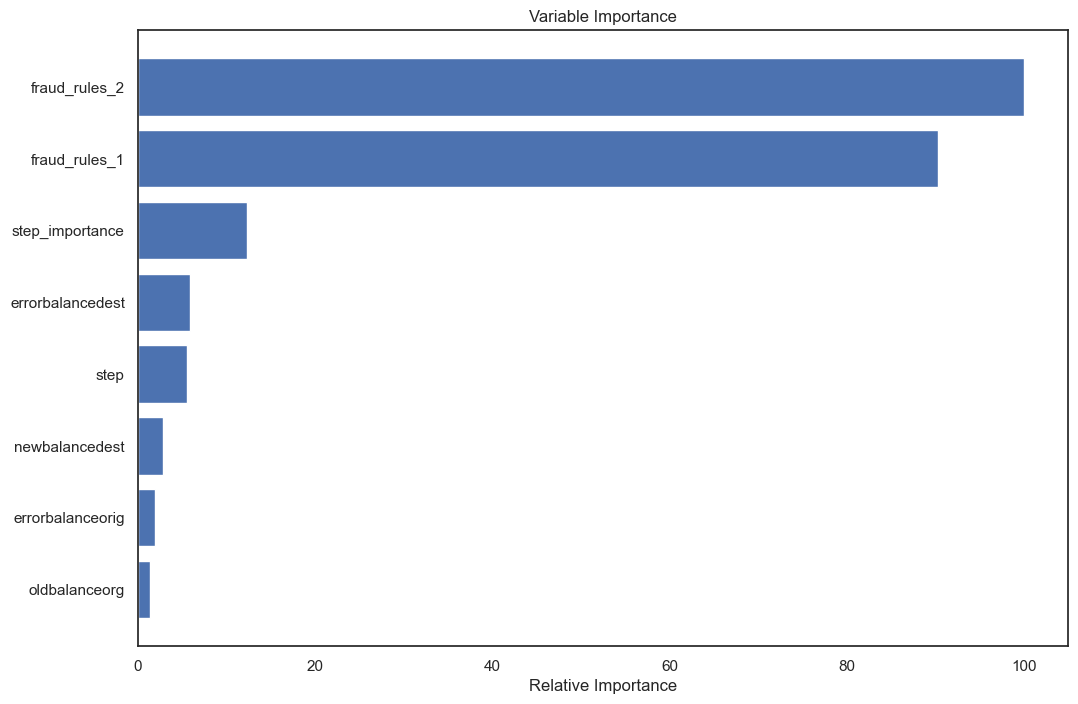

In [55]:
feature_importance = RF.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(12, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train_selected_t.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [56]:

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import IsolationForest


In [57]:
# Se escoge la regresión logística
DT = tree.DecisionTreeClassifier()

# se entrena el modelo con el dataset de entrenamiento
DT.fit(X_train_selected_t, y_train)

from sklearn.metrics import classification_report, confusion_matrix
# predice la clase de test
predictions = DT.predict(X_test_selected_t )

# Evaluate predictions
print(RF.score(X_test_selected_t, y_test)*100)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, DT.predict(X_test_selected_t)))

99.9971389743223
[[209484      3]
 [     5    223]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.99      0.98      0.98       228

    accuracy                           1.00    209715
   macro avg       0.99      0.99      0.99    209715
weighted avg       1.00      1.00      1.00    209715



In [58]:
# Se escoge la regresión logística
LR = LogisticRegression()

# se entrena el modelo con el dataset de entrenamiento
LR.fit(X_train_selected_t, y_train)

from sklearn.metrics import classification_report, confusion_matrix
# predice la clase de test
predictions = LR.predict(X_test_selected_t )

# Evaluate predictions
print(RF.score(X_test_selected_t, y_test)*100)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, LR.predict(X_test_selected_t)))

99.9971389743223
[[209471     16]
 [   205     23]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       0.59      0.10      0.17       228

    accuracy                           1.00    209715
   macro avg       0.79      0.55      0.59    209715
weighted avg       1.00      1.00      1.00    209715



In [59]:
### Parameter Tunning Optimization
param_grid = { 
    'n_estimators': [10,20,50,100,200], # poner tantos como se quiera probar
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

CV = RandomizedSearchCV(RF, param_grid, cv=10, random_state=12345, n_jobs=2)
                  
CV.fit(X_train_selected_t, y_train)  
print(CV.best_params_)    
print(CV.best_score_)

{'n_estimators': 200, 'max_features': 'sqrt', 'max_depth': 8, 'criterion': 'gini'}
0.9999725818372553


In [60]:
# predice la clase de test
predictions = CV.predict(X_test_selected_t )

# Evaluate predictions
print(CV.score(X_test_selected_t, y_test)*100)
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, CV.predict(X_test_selected_t)))

99.9971389743223
[[209487      0]
 [     6    222]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    209487
           1       1.00      0.97      0.99       228

    accuracy                           1.00    209715
   macro avg       1.00      0.99      0.99    209715
weighted avg       1.00      1.00      1.00    209715

